# GPR-Accelerated NEB Tutorial

This tutorial demonstrates how to use `aenet-gpr` for **GPR-accelerated Nudged Elastic Band (NEB) calculations**, which accelerates the demanding NEB calculations for transition state search.

GPR-NEB references:
- [J. A. Garrido Torres, P. C. Jennings, M. H. Hansen, J. R. Boes, and T. Bligaard, “Low-Scaling Algorithm for Nudged Elastic Band Calculations Using a Surrogate Machine Learning Model”, *Phys. Rev. Lett.* 122, 156001 (2019).](https://doi.org/10.1103/PhysRevLett.122.156001)
- [O. Koistinen, F. B. Dagbjartsdóttir, V. Ásgeirsson, A. Vehtari, and H. Jónsson, "Nudged elastic band calculations accelerated with Gaussian process regression", *J. Chem. Phys.* 147, 152720 (2017)](https://doi.org/10.1063/1.4986787)

In this example, we use a simple **EMT potential** as the reference calculator. However, the same framework is fully compatible with any [ASE-compatible DFT calculators](https://wiki.fysik.dtu.dk/ase/ase/calculators/calculators.html).

Replacing the reference with a DFT calculator allows GPR-NEB to reproduce **transition states** on a DFT-level potential energy surface (PES), with **significantly fewer expensive DFT evaluations** than standard NEB.

# ===== Preparation =====

## Reference calculator: Effective Medium Theory (EMT)

In [1]:
try:
    import ase.io
    print("successfully imported ase")
except ImportError:
    !! pip install ase --user --upgrade
    print("completed installing ASE")

successfully imported ase


In [2]:
try:
    from ase.build import add_adsorbate, fcc100
    from ase.calculators.emt import EMT
    from ase.constraints import FixAtoms
    from ase.optimize import QuasiNewton, BFGS, MDMin, FIRE
    print("You are all set for the tutorial.")
except ImportError:
    print("The notebook needs to be restarted. Run this cell again once the restart is done.")
    import os
    os.kill(os.getpid(), 9)

from IPython.display import Image
import copy
import numpy as np

You are all set for the tutorial.


In [3]:
# 2x2-Al(001) surface with 3 layers and an
# Au atom adsorbed in a hollow site:
slab = fcc100('Al', size=(2, 2, 3))
add_adsorbate(slab, 'Au', 1.7, 'hollow')
slab.center(axis=2, vacuum=4.0)

In [4]:
# Fix second and third layers:
mask = [atom.tag > 1 for atom in slab]
# print(mask)
slab.set_constraint(FixAtoms(mask=mask))

In [5]:
# Use EMT potential:
slab.calc = EMT()

In [6]:
# Initial state:
qn = BFGS(slab, trajectory='initial.traj')
qn.run(fmax=0.05)

      Step     Time          Energy          fmax
BFGS:    0 00:31:34        3.323870        0.246170
BFGS:    1 00:31:34        3.321365        0.203512
BFGS:    2 00:31:34        3.314740        0.020557


True

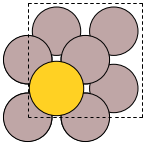

In [7]:
import ase


atoms = ase.io.read('initial.traj')
ase.io.write('initial.png', atoms)
Image("initial.png")

In [8]:
# Final state:
slab[-1].x += slab.get_cell()[0, 0] / 2
qn = BFGS(slab, trajectory='final.traj')
qn.run(fmax=0.05)

      Step     Time          Energy          fmax
BFGS:    0 00:31:35        3.320046        0.123468
BFGS:    1 00:31:35        3.319145        0.111073
BFGS:    2 00:31:35        3.315607        0.074162
BFGS:    3 00:31:35        3.315469        0.075507
BFGS:    4 00:31:35        3.314645        0.052638
BFGS:    5 00:31:35        3.314491        0.027698


True

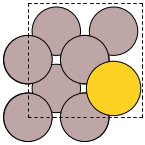

In [9]:
atoms = ase.io.read('final.traj')
ase.io.write('final.png', atoms)
Image("final.png")

# ===== Conventional NEB =====

In [10]:
from ase.calculators.emt import EMT
from ase.constraints import FixAtoms
from ase.io import read
from ase.mep import NEB

In [11]:
initial = read('initial.traj')
final = read('final.traj')

In [12]:
constraint = FixAtoms(mask=[atom.tag > 1 for atom in initial])

In [13]:
images = [initial]
for i in range(5):
    image = initial.copy()
    image.calc = EMT()
    image.set_constraint(constraint)
    images.append(image)

images.append(final)

In [14]:
neb = NEB(images)
neb.interpolate()
qn = FIRE(neb, trajectory='neb.traj')
qn.run(fmax=0.05)

      Step     Time          Energy          fmax
FIRE:    0 00:31:36        4.254555        3.670245
FIRE:    1 00:31:36        4.024620        2.636978
FIRE:    2 00:31:36        3.790869        1.233507
FIRE:    3 00:31:36        3.712369        0.284014
FIRE:    4 00:31:36        3.765949        0.738334
FIRE:    5 00:31:37        3.762147        0.718966
FIRE:    6 00:31:37        3.754943        0.680504
FIRE:    7 00:31:37        3.745105        0.623515
FIRE:    8 00:31:37        3.733711        0.548896
FIRE:    9 00:31:37        3.722050        0.457986
FIRE:   10 00:31:37        3.711497        0.352824
FIRE:   11 00:31:37        3.703339        0.236916
FIRE:   12 00:31:37        3.698253        0.166643
FIRE:   13 00:31:37        3.697729        0.195898
FIRE:   14 00:31:37        3.701253        0.350820
FIRE:   15 00:31:37        3.701012        0.345572
FIRE:   16 00:31:37        3.700548        0.335197
FIRE:   17 00:31:37        3.699887        0.319936
FIRE:   18 00:

True

# Total reference calculations = NEB steps $\times$ number of moving images = 33 $\times$ 5 = 165

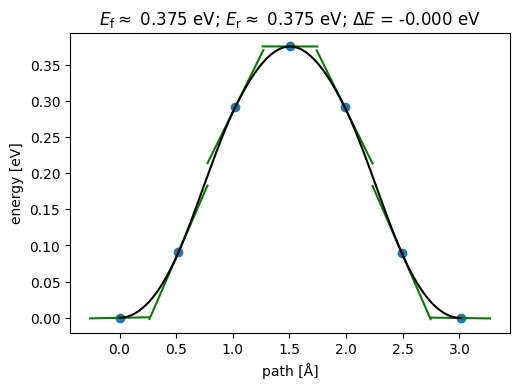

In [15]:
import matplotlib.pyplot as plt

from ase.io import read
from ase.mep import NEBTools

images = read('neb.traj@-7:')

nebtools = NEBTools(images)

# Create a figure with custom parameters.
fig = plt.figure(figsize=(5.5, 4.0))
ax = fig.add_axes((0.15, 0.15, 0.8, 0.75))
nebtools.plot_band(ax)
fig.savefig('diffusion-barrier.png')

# ===== aenet-GPR accelerated NEB =====

### Reference calculator: Effective Medium Theory (EMT)
### Surrogate calculator: aenet-gpr (GPR)

In [16]:
try:
    import torch
    print("successfully imported torch")
    print(torch.__version__)
except ImportError:
    !! pip install torch torchvision torchaudio --user --index-url https://download.pytorch.org/whl/cpu
    print("completed installing torch")

successfully imported torch
2.6.0+cu124


In [17]:
!! pip install aenet-gpr --user --upgrade
print("completed installing aenet-gpr")

! pip show aenet-gpr

completed installing aenet-gpr
Name: aenet-gpr
Version: 1.8.8
Summary: Atomistic simulation tools based on Gaussian Processes Regression
Home-page: https://github.com/atomisticnet/aenet-gpr
Author: In Won Yeu
Author-email: iy2185@columbia.edu
License: MPL-2.0
Location: /data/home/iy2185/.local/lib/python3.12/site-packages
Requires: ase, chemcoord, dscribe
Required-by: 


In [18]:
from aenet_gpr.tool.aidneb import AIDNEB
from aenet_gpr.inout.input_parameter import InputParameters

In [19]:
neb_F_max = 0.05  # cretirian of the force for the convergence.
neb_interpol = "idpp"  # "linear", "idpp", path to trajectory file
neb_n_images = 7  # total images including initial and final
use_mic = False

In [20]:
initial = read('initial.traj')
final = read('final.traj')

In [21]:
calc = EMT()

In [24]:
input_param = InputParameters()

neb = AIDNEB(start=initial,
             end=final,
             interpolation=neb_interpol,
             n_images=neb_n_images,
             mic=use_mic,
             calculator=copy.deepcopy(calc),
             use_previous_observations=True,
             input_param=input_param)

d_start_end:  2.864235082465442
spring_constant:  0.1


In [25]:
neb.run(fmax=neb_F_max, unc_convergence=0.05, dt=0.05, ml_steps=150)

Training data size:  3
Descriptor:  cartesian coordinates
GPR model hyperparameters:  {'kerneltype': 'sqexp', 'scale': tensor(0.4000, dtype=torch.float64), 'weight': tensor(1., dtype=torch.float64), 'noise': tensor(1.0000e-06, dtype=torch.float64), 'noisefactor': tensor(0.5000, dtype=torch.float64), 'prior': tensor(3.5489, dtype=torch.float64)}
      Step     Time          Energy          fmax
FIRE:    0 00:34:02        3.985101        2.657923
FIRE:    1 00:34:03        3.975044        2.666849
FIRE:    2 00:34:04        3.956470        2.670833
FIRE:    3 00:34:05        3.927898        2.642313
FIRE:    4 00:34:06        3.888739        2.542422
FIRE:    5 00:34:07        3.838695        2.329186
FIRE:    6 00:34:08        3.778206        1.996308
FIRE:    7 00:34:09        3.709055        1.547656
FIRE:    8 00:34:10        3.626966        1.154966
FIRE:    9 00:34:12        3.603133        0.877951
FIRE:   10 00:34:13        3.598571        0.478328
FIRE:   11 00:34:14        3.59

# Total reference calculations = Training data size (10) $-$ initial and final images (2) = 8

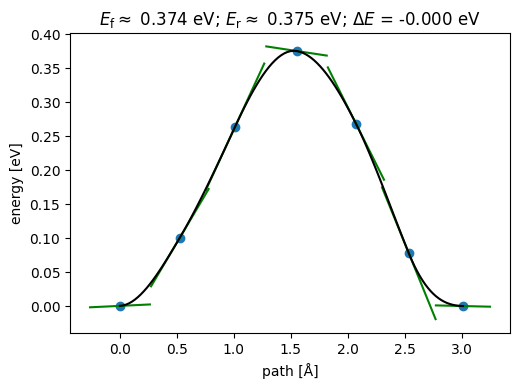

In [26]:
images = read('AIDNEB.traj@-7:')

nebtools = NEBTools(images)

# Create a figure with custom parameters.
fig = plt.figure(figsize=(5.5, 4.0))
ax = fig.add_axes((0.15, 0.15, 0.8, 0.75))
nebtools.plot_band(ax)
fig.savefig('diffusion-barrier.png')